## Import all libraries that will be used

In [19]:
# Import all usefull library
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import squarify


## Data Visualization and Brief Introduction
- Source: https://www.kaggle.com/code/daniilkrasnoproshin/random-forest-for-regression-problems/notebook
- Include gold, silver crude oil price from 2008 to 2018, along with SPX and EUR/USD during this period.

In [20]:
# read data
gold_data = pd.read_csv('gold_price_dataset_preprocessed.csv')
print(gold_data.head(5))
print(gold_data.info())

   Unnamed: 0        Date          SPX        GLD        USO     SLV  \
0           1  2008-01-02  1447.160034  84.860001  78.470001  15.180   
1           2  2008-01-03  1447.160034  85.570000  78.370003  15.285   
2           3  2008-01-04  1411.630005  85.129997  77.309998  15.167   
3           4  2008-01-07  1416.180054  84.769997  75.500000  15.053   
4           5  2008-01-08  1390.189941  86.779999  76.059998  15.590   

    EUR.USD  day  month  year      lag_SPX    lag_GLD    lag_USO  lag_SLV  \
0  1.471692    2      1  2008          NaN        NaN        NaN      NaN   
1  1.474491    3      1  2008  1447.160034  84.860001  78.470001   15.180   
2  1.475492    4      1  2008  1447.160034  85.570000  78.370003   15.285   
3  1.468299    7      1  2008  1411.630005  85.129997  77.309998   15.167   
4  1.557099    8      1  2008  1416.180054  84.769997  75.500000   15.053   

   lag_EUR.USD  norm_SPX  norm_USO  norm_SLV  norm_EUR.USD gold_label  
0          NaN  0.350870  0.6438

## Data preprocessing

In [21]:
# Normalize all data
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

gold_data["norm_SPX"] = normalize(gold_data["SPX"])
gold_data["norm_GLD"] = normalize(gold_data["GLD"])
gold_data["norm_USO"] = normalize(gold_data["USO"])
gold_data["norm_SLV"] = normalize(gold_data["SLV"])
gold_data["norm_EURUSD"] = normalize(gold_data["EUR.USD"])


# Change Date data format
gold_data["Date"] = pd.to_datetime(gold_data["Date"])


# add log return to help labelinng up/down/same 
columns = ['SPX', 'GLD', 'USO', 'SLV']
prices = gold_data[columns]

log_returns = np.log(prices / prices.shift(1)).dropna()

print(gold_data.head(10))


   Unnamed: 0       Date          SPX        GLD        USO        SLV  \
0           1 2008-01-02  1447.160034  84.860001  78.470001  15.180000   
1           2 2008-01-03  1447.160034  85.570000  78.370003  15.285000   
2           3 2008-01-04  1411.630005  85.129997  77.309998  15.167000   
3           4 2008-01-07  1416.180054  84.769997  75.500000  15.053000   
4           5 2008-01-08  1390.189941  86.779999  76.059998  15.590000   
5           6 2008-01-09  1409.130005  86.550003  75.250000  15.520000   
6           7 2008-01-10  1420.329956  88.250000  74.019997  16.061001   
7           8 2008-01-11  1401.020020  88.580002  73.089996  16.077000   
8           9 2008-01-14  1416.250000  89.540001  74.250000  16.280001   
9          10 2008-01-15  1380.949951  87.989998  72.779999  15.834000   

    EUR.USD  day  month  year  ...    lag_USO    lag_SLV  lag_EUR.USD  \
0  1.471692    2      1  2008  ...        NaN        NaN          NaN   
1  1.474491    3      1  2008  ...  78.

## Data visulaization

In [22]:
# Compute correlation matrix of log returns
# correlation_matrix = log_returns.corr()

# print(correlation_matrix)

# # Correlation Heatmap
# plt.figure(figsize=(8, 6))
# correlation_matrix = gold_data[["SPX", "GLD", "USO", "SLV", "EUR.USD"]].corr()
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Heatmap of Key Features", fontsize=14, pad=20)
# plt.savefig("Correlation figure_v1")
# plt.show()



# # Line Plot for Normalized Features Over Time
# plt.figure(figsize=(12, 6))
# for column, label in zip(["norm_SPX", "norm_GLD", "norm_USO", "norm_SLV", "norm_EURUSD"], 
#                          ["SPX", "Gold Price", "Oil Price", "Silver Price", "EUR/USD"]):
#     plt.plot(gold_data['Date'], gold_data[column], label=label)

# # Format the X-axis to show year only
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
# plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# plt.title("Normalized Time Series Trends", fontsize=14, pad=10)
# plt.xlabel("Year")
# plt.ylabel("Normalized Value")
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)
# plt.savefig("Normalized Time Series Trends_v1")
# plt.show()



# # Boxplot for Normalized Features by Gold Label
# plt.figure(figsize=(10, 6))
# melted_data = gold_data.melt(id_vars="gold_label", 
#                         value_vars=["norm_SPX", "norm_USO", "norm_SLV", "norm_EURUSD"], 
#                         var_name="Feature", value_name="Normalized Value")
# sns.boxplot(data=melted_data, x="Feature", y="Normalized Value", hue="gold_label", palette="Set2")
# plt.title("Feature Distributions by Gold Label", fontsize=14, pad=20)
# plt.xlabel("Feature", fontsize=10)
# plt.ylabel("Distribution", fontsize=10)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
# plt.savefig("Boxplot for Normalized Features by Gold Label_v1")
# plt.show()



# # Scatter Plot Matrix of Features
# plt.figure(figsize=(8, 10))
# sns.pairplot(gold_data[["SPX", "GLD", "USO", "SLV", "EUR.USD"]], corner=True, diag_kind="kde")
# plt.suptitle("Scatter Plot Matrix of Key Features", fontsize=14, y=1.02)
# plt.savefig("Scatter plot of Each Variables_v1")
# plt.show()

## Add label for association analysis

In [23]:
#  Discretize the continuous data into categories (Up, Down, Neutral) based on daily log returns
def categorize(value, threshold=0.005):
    if value > threshold:
        return "Up"
    elif value < -threshold:
        return "Down"
    else:
        return "Same"

# Apply categorization to log returns
discretized_data = log_returns.applymap(lambda x: categorize(x))

# Convert to transactional format
transactional_data = pd.get_dummies(discretized_data)

# Generate candidate itemsets
def get_candidate_itemsets(itemsets, length):
    return set([frozenset(i.union(j)) for i in itemsets for j in itemsets if len(i.union(j)) == length])

# Function to calculate support for itemsets
def calculate_support(transactional_data, itemsets):
    support = defaultdict(int)
    num_transactions = len(transactional_data)
    for transaction in transactional_data:
        for itemset in itemsets:
            if itemset.issubset(transaction):
                support[itemset] += 1
    return {itemset: count / num_transactions for itemset, count in support.items()}

# Generate transactions from transactional data
transactions = transactional_data.apply(lambda row: frozenset(row[row == 1].index), axis=1).tolist()

## Apriori

                          itemsets   support
0                         (SLV_Up)  0.373526
1                       (USO_Same)  0.234163
2                         (GLD_Up)  0.296199
3                       (SPX_Same)  0.486239
4                       (SLV_Down)  0.342071
5                       (USO_Down)  0.383137
6                       (GLD_Down)  0.274792
7                       (SPX_Down)  0.225863
8                       (GLD_Same)  0.429008
9                         (USO_Up)  0.382700
10                      (SLV_Same)  0.284404
11                        (SPX_Up)  0.287899
12            (USO_Same, SPX_Same)  0.140236
13              (GLD_Up, SPX_Same)  0.127567
14              (SLV_Up, SPX_Same)  0.166448
15                (SLV_Up, GLD_Up)  0.249891
16            (USO_Down, GLD_Down)  0.151158
17            (SLV_Down, USO_Down)  0.179991
18            (USO_Down, SPX_Down)  0.143294
19            (SLV_Down, GLD_Down)  0.227610
20            (SLV_Down, SPX_Down)  0.104412
21        

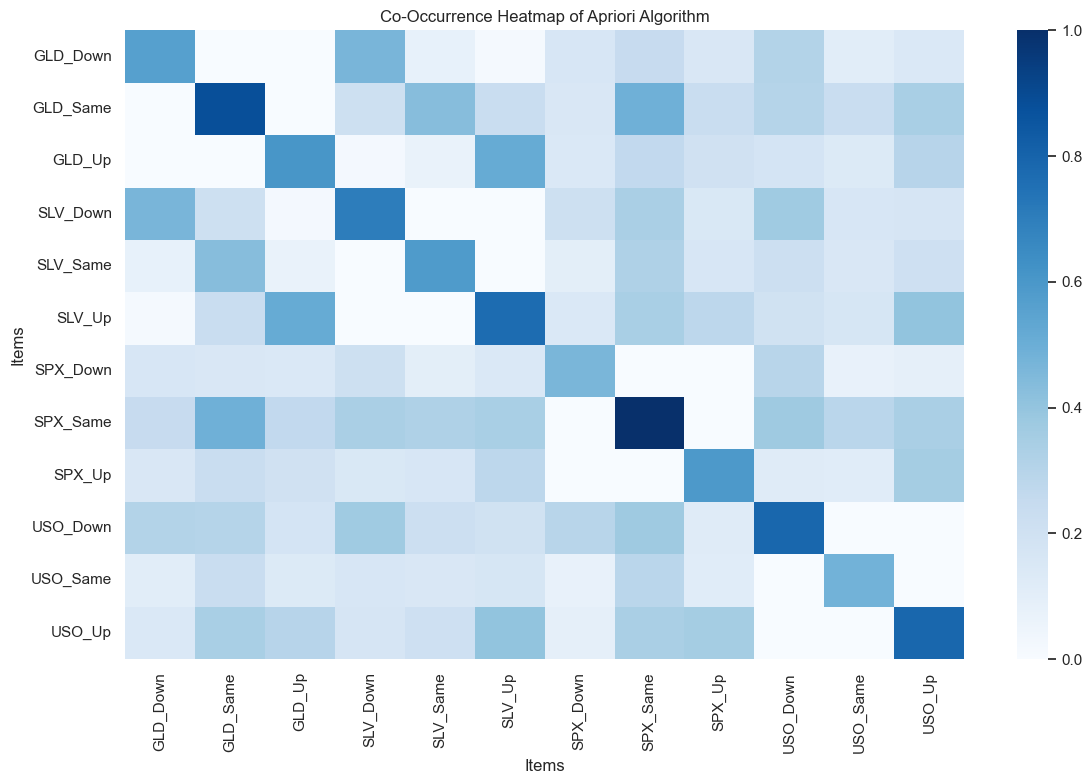

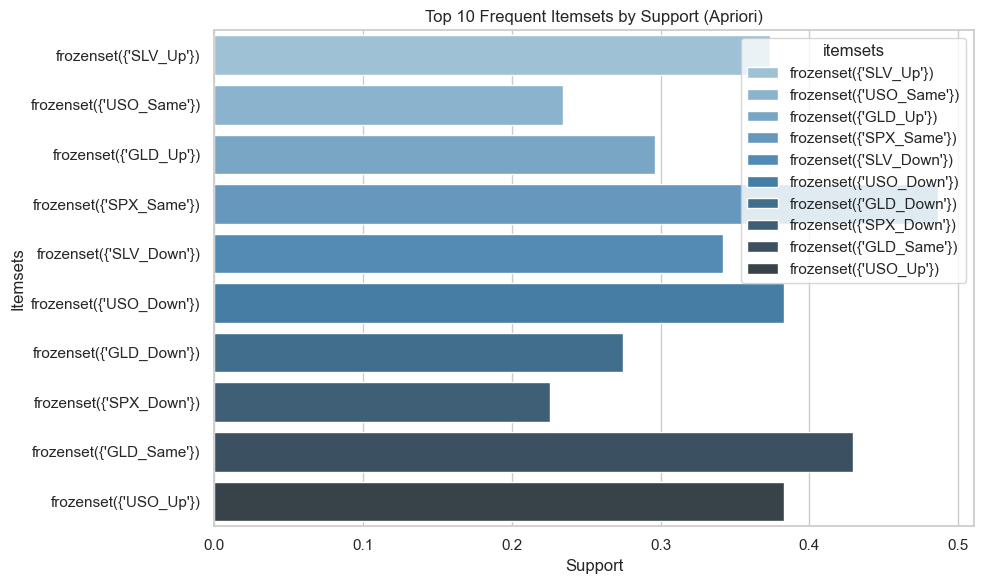

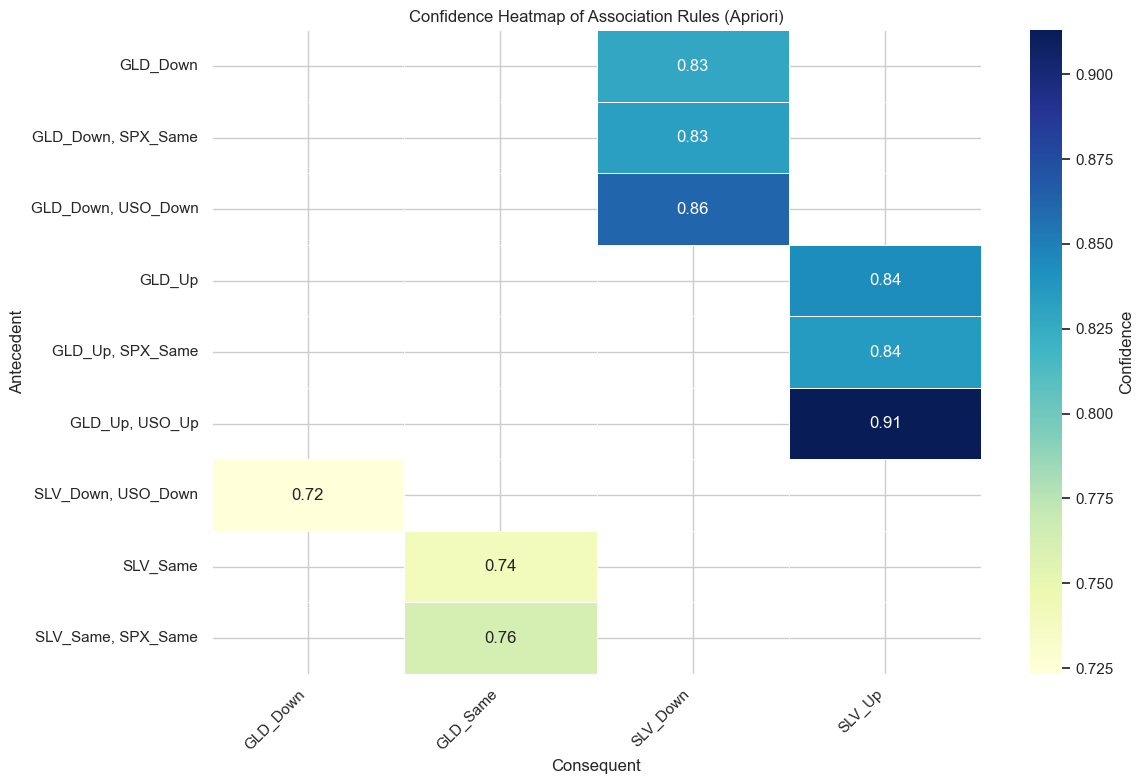

In [28]:
# Apriori implementation
def generate_rules(frequent_itemsets, min_confidence=0.7):
    rules = []
    for itemset, support_itemset in frequent_itemsets.items():
        if len(itemset) > 1:  # Only generate rules for itemsets with more than one item
            for r in range(1, len(itemset)):
                for antecedent in combinations(itemset, r):
                    antecedent = frozenset(antecedent)
                    consequent = itemset - antecedent
                    support_antecedent = frequent_itemsets.get(antecedent, 0)
                    support_consequent = frequent_itemsets.get(consequent, 0)
                    if support_antecedent > 0:
                        confidence = support_itemset / support_antecedent
                        lift = confidence / support_consequent if support_consequent > 0 else 0
                        if confidence >= min_confidence:
                            rules.append({
                                'antecedent': antecedent,
                                'consequent': consequent,
                                'support': support_itemset,
                                'confidence': confidence,
                                'lift': lift
                            })
    return pd.DataFrame(rules)

def apriori_algorithm(transactions, min_support=0.1):
    # Initial pass to find single-item frequent itemsets
    single_items = {frozenset([item]): 0 for transaction in transactions for item in transaction}
    for transaction in transactions:
        for item in transaction:
            single_items[frozenset([item])] += 1

    # Convert to relative support
    num_transactions = len(transactions)
    single_items = {item: support / num_transactions for item, support in single_items.items()}
    frequent_itemsets = {itemset: support for itemset, support in single_items.items() if support >= min_support}

    # Generate larger itemsets iteratively
    current_itemsets = set(frequent_itemsets.keys())
    k = 2
    while current_itemsets:
        candidate_itemsets = get_candidate_itemsets(current_itemsets, k)
        candidate_support = calculate_support(transactions, candidate_itemsets)
        frequent_k_itemsets = {itemset: support for itemset, support in candidate_support.items() if support >= min_support}
        frequent_itemsets.update(frequent_k_itemsets)
        current_itemsets = set(frequent_k_itemsets.keys())
        k += 1

    return frequent_itemsets

# Apply Apriori algorithm to transactions
frequent_itemsets = apriori_algorithm(transactions, min_support=0.1)


# Convert to DataFram for display
frequent_itemsets_df = pd.DataFrame([{'itemsets': itemset, 'support': support} for itemset, support in frequent_itemsets.items()])

frequent_itemsets_df.head()
print(frequent_itemsets_df)
frequent_itemsets_df.to_csv("itemset_ap.csv", index=False)



min_confidence = 0.7
rules_ap = generate_rules(frequent_itemsets, min_confidence)
rules_ap.to_csv("rules_ap.csv", index=False)

print(rules_ap)





# Generate a co-occurrence matrix from transactional data
def generate_cooccurrence_matrix(transactions):
    items = sorted({item for transaction in transactions for item in transaction})
    item_index = {item: idx for idx, item in enumerate(items)}
    cooccurrence_matrix = np.zeros((len(items), len(items)))

    for transaction in transactions:
        for item1 in transaction:
            for item2 in transaction:
                cooccurrence_matrix[item_index[item1], item_index[item2]] += 1

    return cooccurrence_matrix, items

# Generate the matrix
cooccurrence_matrix, items = generate_cooccurrence_matrix(transactions)

# Normalize the co-occurrence matrix
cooccurrence_matrix_normalized = cooccurrence_matrix / cooccurrence_matrix.max()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cooccurrence_matrix_normalized,
    xticklabels=items,
    yticklabels=items,
    cmap="Blues",
    annot=False,
    cbar=True,
)
plt.title("Co-Occurrence Heatmap of Apriori Algorithm")
plt.xlabel("Items")
plt.ylabel("Items")
plt.tight_layout()
plt.show()


# Visualization: Top 10 Frequent Itemsets by Support
top_10_frequent_itemsets = frequent_itemsets_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_frequent_itemsets, x='support', y='itemsets', hue="itemsets", palette="Blues_d")
plt.title("Top 10 Frequent Itemsets by Support (Apriori)")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.tight_layout()
plt.show()

# Visualization: Confidence Heatmap
rules_ap['antecedent'] = rules_ap['antecedent'].apply(lambda x: ', '.join(sorted(list(x))))
rules_ap['consequent'] = rules_ap['consequent'].apply(lambda x: ', '.join(sorted(list(x))))
pivot_table = rules_ap.pivot(index='antecedent', columns='consequent', values='confidence')

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Confidence'},
    linewidths=0.5,
)
plt.title("Confidence Heatmap of Association Rules (Apriori)")
plt.xlabel("Consequent")
plt.ylabel("Antecedent")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## FP-Growth

             antecedent  consequent   support  confidence      lift
0              (GLD_Up)    (SLV_Up)  0.249891    0.843658  2.258635
1    (GLD_Up, SPX_Same)    (SLV_Up)  0.106597    0.835616  2.237106
2      (GLD_Up, USO_Up)    (SLV_Up)  0.132809    0.912913  2.444044
3            (GLD_Down)  (SLV_Down)  0.227610    0.828299  2.421425
4  (SLV_Down, USO_Down)  (GLD_Down)  0.130188    0.723301  2.632172
5  (USO_Down, GLD_Down)  (SLV_Down)  0.130188    0.861272  2.517817
6  (GLD_Down, SPX_Same)  (SLV_Down)  0.100044    0.832727  2.434371
7            (SLV_Same)  (GLD_Same)  0.210572    0.740399  1.725839
8  (SPX_Same, SLV_Same)  (GLD_Same)  0.118829    0.761905  1.775967


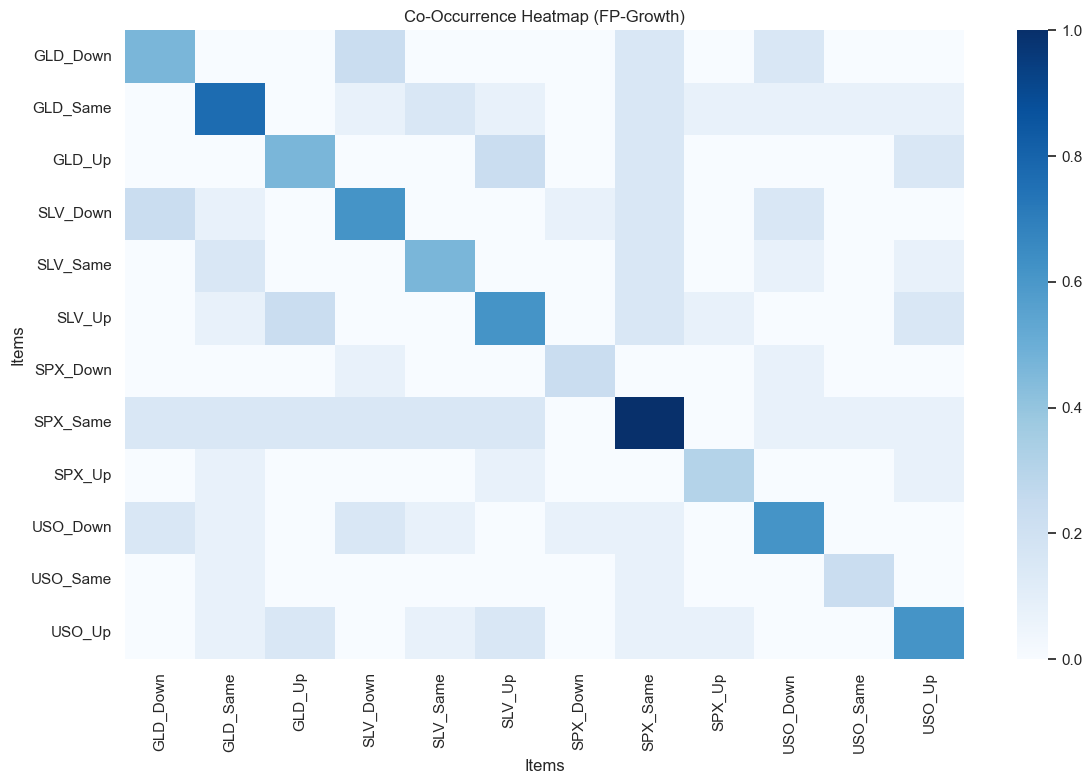

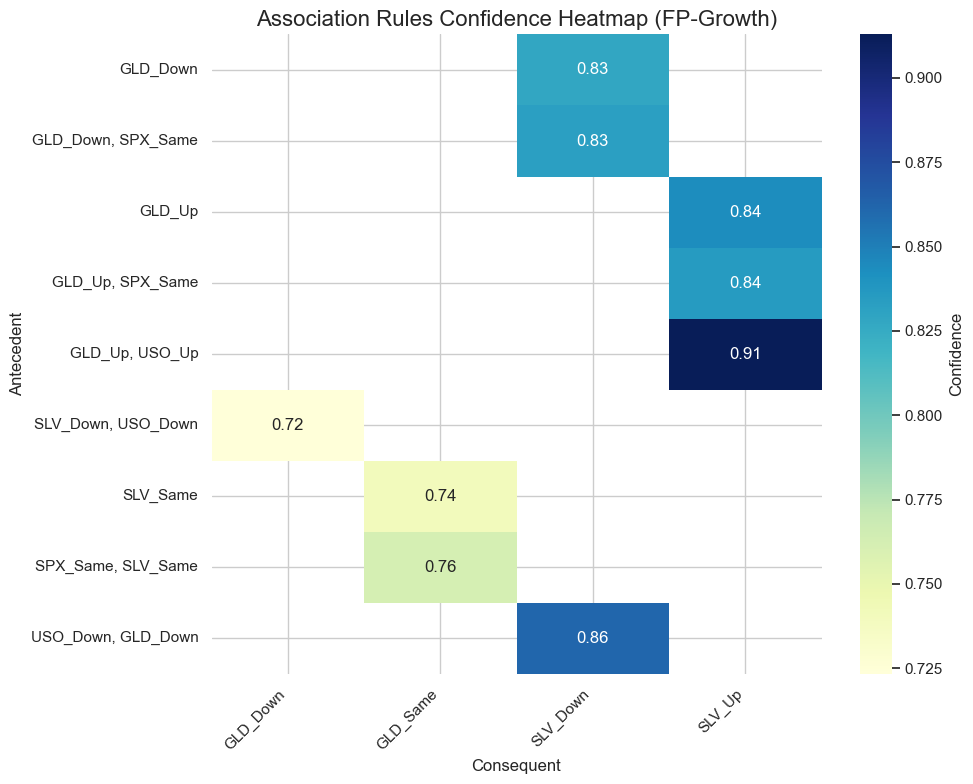

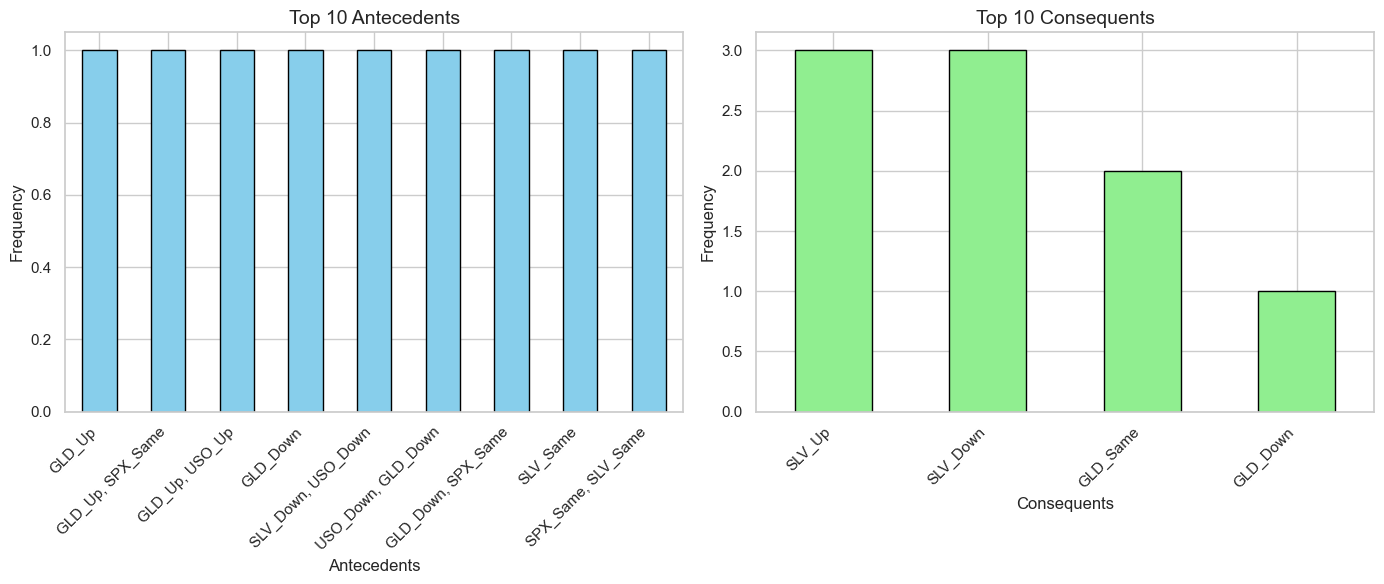

In [ ]:
# FP-Growth Algorithm

def generate_rules(frequent_itemsets, min_confidence):
    rules = []
    for _, row in frequent_itemsets.iterrows():
        itemset = row['itemsets']
        support_itemset = row['support']
        for r in range(1, len(itemset)):
            for antecedent in combinations(itemset, r):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent  # Ensure itemset is a frozenset
                support_antecedent = frequent_itemsets[frequent_itemsets['itemsets'] == antecedent]['support'].sum()
                confidence = support_itemset / support_antecedent if support_antecedent > 0 else 0
                if confidence >= min_confidence:
                    lift = confidence / (frequent_itemsets[frequent_itemsets['itemsets'] == consequent]['support'].sum())
                    rules.append({
                        'antecedent': antecedent,
                        'consequent': consequent,
                        'support': support_itemset,
                        'confidence': confidence,
                        'lift': lift
                    })
    return pd.DataFrame(rules)

# Apply FP-Growth algorithm to transactional data
frequent_itemsets_fp = fpgrowth(transactional_data, min_support=0.1, use_colnames=True)

frequent_itemsets_fp.to_csv("itemset_fp.csv")

# Generate association rules from FP-Growth results
rules_fp = generate_rules(frequent_itemsets_fp, min_confidence=0.7)
rules_fp.to_csv("rules_fp.csv")
print(rules_fp)

# # Prepare data for visualization: Top 5 rules by lift
# top_rules_fp = rules_fp.sort_values(by="lift", ascending=False).head(5)

# # Plot bar chart of top rules by lift
# plt.figure(figsize=(10, 6))
# plt.bar(
#     range(len(top_rules_fp)),
#     top_rules_fp["lift"],
#     tick_label=[f"{', '.join(map(str, list(a)))} → {', '.join(map(str, list(c)))}" 
#                 for a, c in zip(top_rules_fp["antecedent"], top_rules_fp["consequent"])],
# )
# plt.xticks(rotation=45, ha="right")
# plt.title("Top 5 Association Rules by Lift (FP-Growth)")
# plt.xlabel("Rules")
# plt.ylabel("Lift")
# plt.tight_layout()
# plt.show()

def generate_fp_cooccurrence_matrix(frequent_itemsets_fp):
    items = sorted({item for itemset in frequent_itemsets_fp['itemsets'] for item in itemset})
    item_index = {item: idx for idx, item in enumerate(items)}
    cooccurrence_matrix = np.zeros((len(items), len(items)))

    for itemset in frequent_itemsets_fp['itemsets']:
        for item1 in itemset:
            for item2 in itemset:
                cooccurrence_matrix[item_index[item1], item_index[item2]] += 1

    return cooccurrence_matrix, items

# Generate co-occurrence matrix from FP-Growth frequent itemsets
cooccurrence_matrix_fp, items_fp = generate_fp_cooccurrence_matrix(frequent_itemsets_fp)

# Normalize co-occurrence matrix for visualization
cooccurrence_matrix_fp_normalized = cooccurrence_matrix_fp / cooccurrence_matrix_fp.max()

# Plot heatmap for FP-Growth results
plt.figure(figsize=(12, 8))
sns.heatmap(
    cooccurrence_matrix_fp_normalized,
    xticklabels=items_fp,
    yticklabels=items_fp,
    cmap="Blues",
    annot=False,
    cbar=True,
)
plt.title("Co-Occurrence Heatmap (FP-Growth)")
plt.xlabel("Items")
plt.ylabel("Items")
plt.tight_layout()
plt.show()


# Visualization: Confidence Heatmap
plt.figure(figsize=(10, 8))
rules_fp['antecedent'] = rules_fp['antecedent'].apply(lambda x: ', '.join(list(x)))
rules_fp['consequent'] = rules_fp['consequent'].apply(lambda x: ', '.join(list(x)))
pivot_table = rules_fp.pivot(index='antecedent', columns='consequent', values='confidence')
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Confidence'})
plt.title('Association Rules Confidence Heatmap (FP-Growth)', fontsize=16)
plt.xlabel('Consequent', fontsize=12)
plt.ylabel('Antecedent', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization: Top Antecedents and Consequents
top_antecedents = rules_fp['antecedent'].value_counts().head(10)
top_consequents = rules_fp['consequent'].value_counts().head(10)

plt.figure(figsize=(14, 6))

# Top Antecedents
plt.subplot(1, 2, 1)
top_antecedents.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Antecedents', fontsize=14)
plt.ylabel('Frequency')
plt.xlabel('Antecedents')
plt.xticks(rotation=45, ha='right')

# Top Consequents
plt.subplot(1, 2, 2)
top_consequents.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Top 10 Consequents', fontsize=14)
plt.ylabel('Frequency')
plt.xlabel('Consequents')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## ECLAT

     antecedent          consequent   support  confidence      lift
0      (USO_Up)            (SPX_Up)  0.382700    1.000000  3.473445
1      (SPX_Up)            (USO_Up)  0.382700    1.329287  3.473445
2    (GLD_Same)    (USO_Up, SPX_Up)  0.429008    1.000000  2.613014
3      (USO_Up)  (SPX_Up, GLD_Same)  0.429008    1.121005  2.613014
4      (SPX_Up)  (USO_Up, GLD_Same)  0.429008    1.490137  3.473445
..          ...                 ...       ...         ...       ...
285  (USO_Same)          (SPX_Same)  0.234163    1.000000  2.056604
286    (SLV_Up)          (SPX_Same)  0.373526    1.000000  2.056604
287  (SPX_Same)            (SLV_Up)  0.373526    0.768194  2.056604
288    (SLV_Up)            (GLD_Up)  0.373526    1.000000  3.376106
289    (GLD_Up)            (SLV_Up)  0.373526    1.261062  3.376106

[290 rows x 5 columns]
                              itemsets   support
0                             (SPX_Up)  0.287899
1                     (USO_Up, SPX_Up)  0.382700
2           (

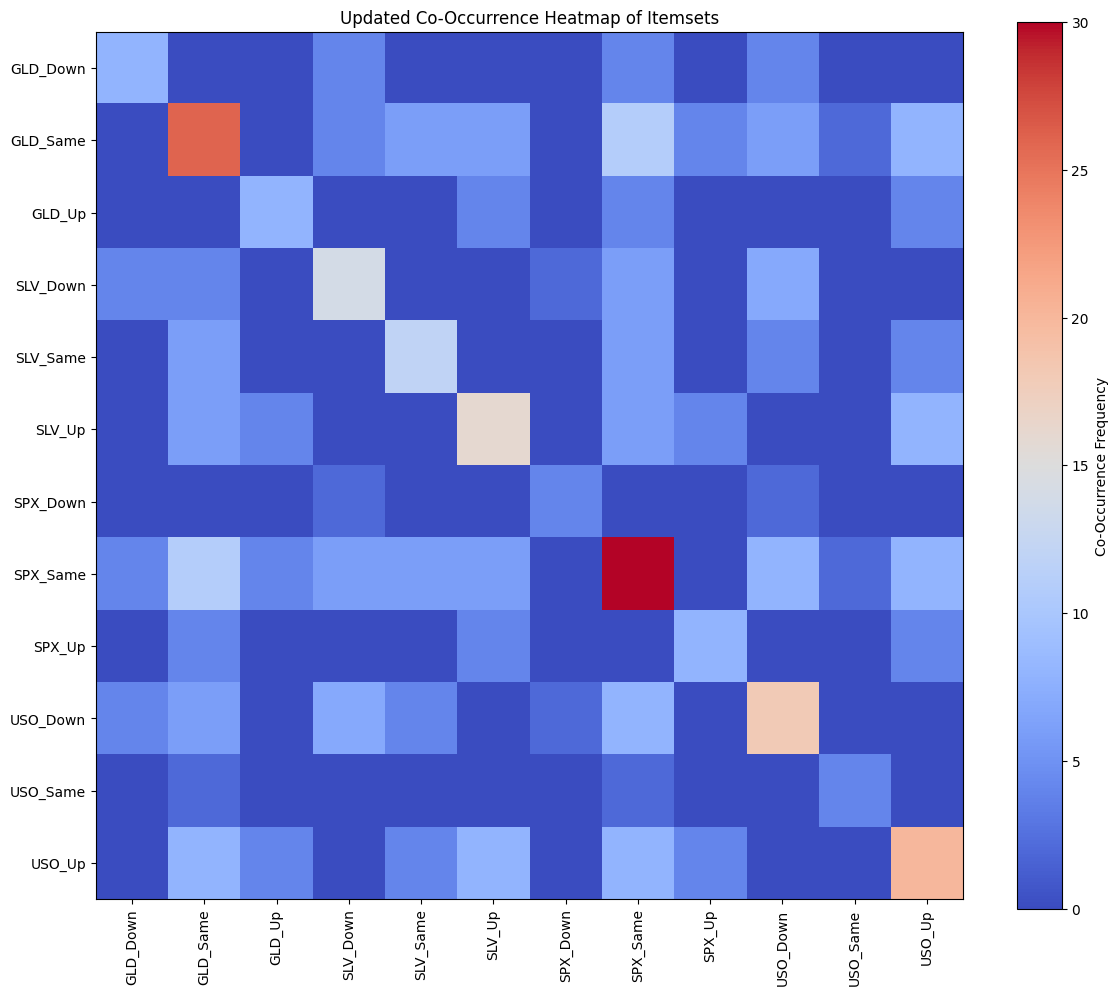

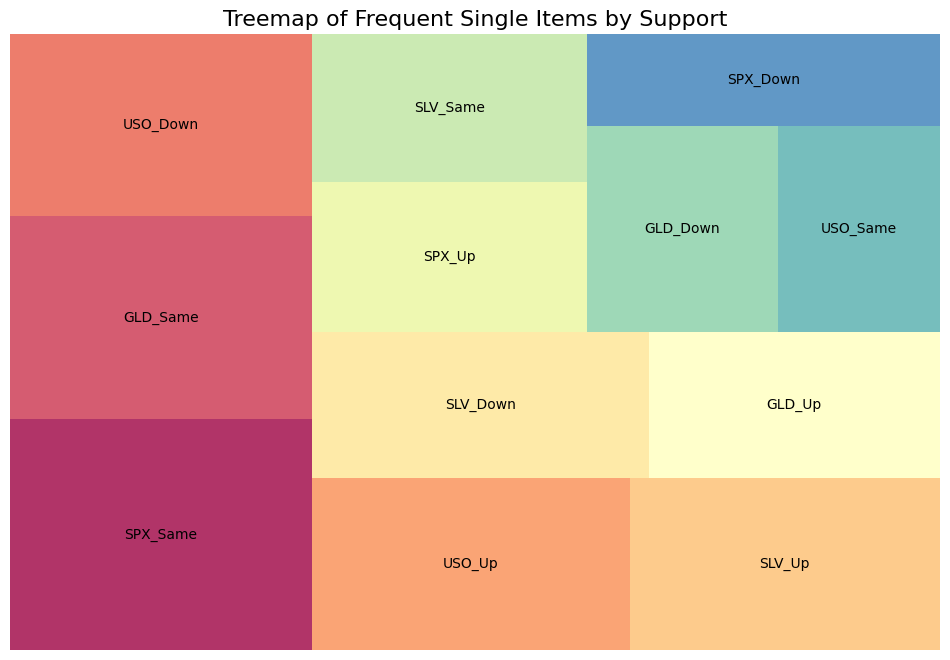

In [ ]:


#  Convert transactional data into vertical format (item → transaction IDs)
def vertical_format(transactions):
    vertical_db = defaultdict(set)
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            vertical_db[item].add(tid)
    return vertical_db

# ECLA: find frequent itemsets
def eclat(vertical_db, min_support, num_transactions):
    frequent_itemsets = {}
    def recursive_eclat(prefix, items):
        while items:
            item = items.pop()
            item_tidset = vertical_db[item]
            support = len(item_tidset) / num_transactions
            if support >= min_support:
                new_prefix = prefix.union({item})
                frequent_itemsets[frozenset(new_prefix)] = support
                new_items = []
                for other_item in items:
                    other_tidset = vertical_db[other_item]
                    intersection_tidset = item_tidset & other_tidset
                    if len(intersection_tidset) / num_transactions >= min_support:
                        vertical_db[frozenset(new_prefix.union({other_item}))] = intersection_tidset
                        new_items.append(other_item)
                recursive_eclat(new_prefix, new_items)
    recursive_eclat(frozenset(), list(vertical_db.keys()))
    return frequent_itemsets

# Generate transactions from transactional data
transactions = transactional_data.apply(lambda row: frozenset(row[row == 1].index), axis=1).tolist()
vertical_db = vertical_format(transactions)

# Apply ECLAT
num_transactions = len(transactions)
min_support = 0.1
frequent_itemsets_eclat = eclat(vertical_db, min_support, num_transactions)

# Generate association rules
def generate_rules(frequent_itemsets, min_confidence=0.7):
    rules = []
    for itemset, support_itemset in frequent_itemsets.items():
        if len(itemset) > 1:
            for r in range(1, len(itemset)):
                for antecedent in combinations(itemset, r):
                    antecedent = frozenset(antecedent)
                    consequent = itemset - antecedent
                    support_antecedent = frequent_itemsets.get(antecedent, 0)
                    support_consequent = frequent_itemsets.get(consequent, 0)
                    if support_antecedent > 0:
                        confidence = support_itemset / support_antecedent
                        lift = confidence / support_consequent if support_consequent > 0 else 0
                        if confidence >= min_confidence:
                            rules.append({
                                'antecedent': antecedent,
                                'consequent': consequent,
                                'support': support_itemset,
                                'confidence': confidence,
                                'lift': lift
                            })
    return pd.DataFrame(rules)

# Generate rules from ECLAT frequent itemsets
min_confidence = 0.7
rules_eclat = generate_rules(frequent_itemsets_eclat, min_confidence)
rules_eclat.to_csv("rules_eclat.csv")
print(rules_eclat)


# Convert results to a DataFrame for display
frequent_itemsets_eclat_df = pd.DataFrame(
    [{'itemsets': itemset, 'support': support} for itemset, support in frequent_itemsets_eclat.items()]
)

print(frequent_itemsets_eclat_df)

frequent_itemsets_eclat_df.to_excel("frequent_itemsets_eclat.xlsx")

# Ensure the itemsets column is in the correct format
# If the column is already frozensets, no conversion is needed
if isinstance(frequent_itemsets_eclat_df['itemsets'].iloc[0], frozenset):
    itemsets_updated = frequent_itemsets_eclat_df['itemsets'].tolist()
else:
    itemsets_updated = frequent_itemsets_eclat_df['itemsets'].apply(lambda x: frozenset(eval(x))).tolist()

# Create a list of all unique items in the updated data
unique_items_updated = sorted(set(item for itemset in itemsets_updated for item in itemset))

# Initialize an empty co-occurrence matrix for the updated data
co_occurrence_matrix_updated = np.zeros((len(unique_items_updated), len(unique_items_updated)))

# Populate the co-occurrence matrix for the updated data
for itemset in itemsets_updated:
    for item1 in itemset:
        for item2 in itemset:
            idx1 = unique_items_updated.index(item1)
            idx2 = unique_items_updated.index(item2)
            co_occurrence_matrix_updated[idx1, idx2] += 1

# Create a heatmap of the updated co-occurrence matrix
plt.figure(figsize=(12, 10))
plt.imshow(co_occurrence_matrix_updated, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Co-Occurrence Frequency')
plt.xticks(ticks=range(len(unique_items_updated)), labels=unique_items_updated, rotation=90)
plt.yticks(ticks=range(len(unique_items_updated)), labels=unique_items_updated)
plt.title('Updated Co-Occurrence Heatmap of Itemsets')
plt.tight_layout()
plt.show()


# Filter to single-item itemsets
singletons = {itemset: support for itemset, support in frequent_itemsets_eclat.items() if len(itemset) == 1}

# Convert dictionary to DataFrame
df_singletons = pd.DataFrame({
    'item': [list(itemset)[0] for itemset in singletons.keys()],
    'support': list(singletons.values())
})

# Sort by support for a more intuitive view (largest first)
df_singletons = df_singletons.sort_values('support', ascending=False).reset_index(drop=True)

# Plot the treemap
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=df_singletons['support'], 
    label=df_singletons['item'], 
    alpha=0.8,
    color=plt.cm.Spectral(df_singletons.index / float(len(df_singletons)))
)

plt.title("Treemap of Frequent Single Items by Support", fontsize=16)
plt.axis('off')
plt.show()


## Comparision

C:\Users\75107\AppData\Local\Temp\ipykernel_69644\1935059587.py:41: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x="Support", y="Itemsets", hue="Algorithm", data=support_comparison, palette=palette)


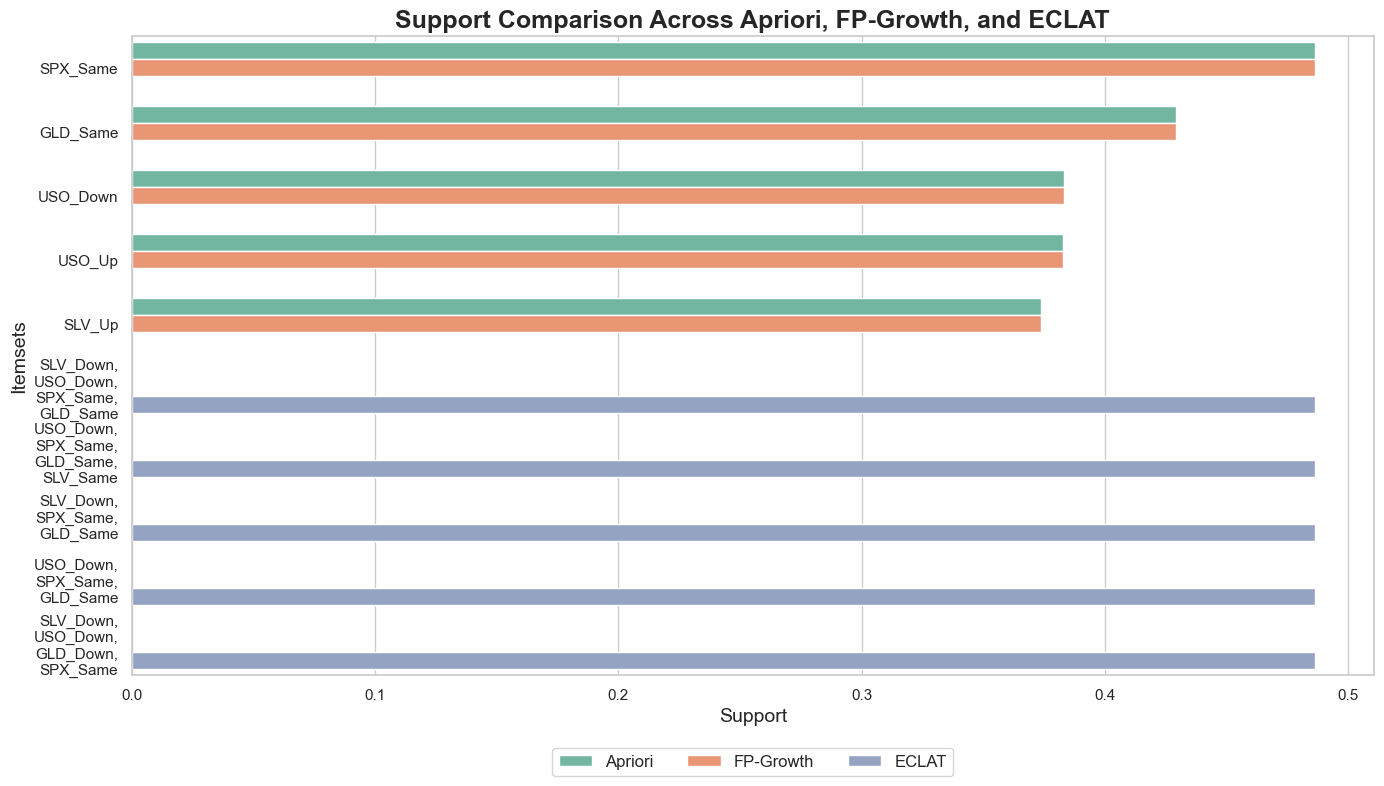

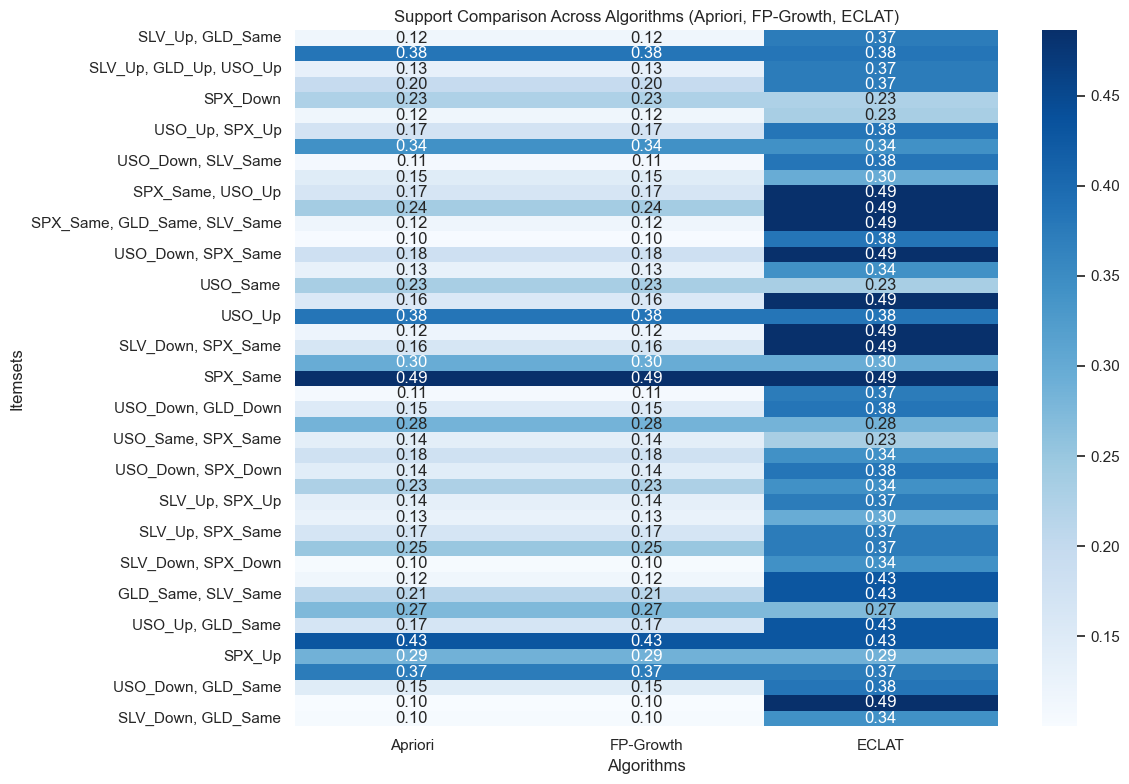

In [ ]:
# Ensure all necessary data is available and use placeholders for comparison if needed
# Assuming `frequent_itemsets`, `frequent_itemsets_fp`, and `frequent_itemsets_eclat_df` are already computed

# Extract top 5 frequent itemsets by support from each algorithm for comparison
top_apriori = frequent_itemsets_df.sort_values(by="support", ascending=False).head(5)
top_fp_growth = frequent_itemsets_fp.sort_values(by="support", ascending=False).head(5)
top_eclat = frequent_itemsets_eclat_df.sort_values(by="support", ascending=False).head(5)

# Combine results into a single DataFrame for comparison
support_comparison = pd.DataFrame({
    "Itemsets": [
        ', '.join(map(str, list(item))) for item in
        top_apriori["itemsets"].tolist() +
        top_fp_growth["itemsets"].tolist() +
        top_eclat["itemsets"].tolist()
    ],
    "Support": top_apriori["support"].tolist() + 
               top_fp_growth["support"].tolist() + 
               top_eclat["support"].tolist(),
    "Algorithm": ["Apriori"] * len(top_apriori) + 
                 ["FP-Growth"] * len(top_fp_growth) + 
                 ["ECLAT"] * len(top_eclat)
})

# Bar chart to compare support across algorithms
# plt.figure(figsize=(14, 8))
# sns.barplot(x="Support", y="Itemsets", hue="Algorithm", data=support_comparison)
# plt.title("Support Comparison Across Apriori, FP-Growth, and ECLAT")
# plt.xlabel("Support")
# plt.ylabel("Itemsets")
# plt.tight_layout()
# plt.show()


sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))
palette = sns.color_palette("Set2")

support_comparison["Itemsets"] = support_comparison["Itemsets"].apply(lambda x: x.replace(", ", ",\n"))

sns.barplot(x="Support", y="Itemsets", hue="Algorithm", data=support_comparison, palette=palette)
plt.title("Support Comparison Across Apriori, FP-Growth, and ECLAT", fontsize=18, weight='bold')
plt.xlabel("Support", fontsize=14)
plt.ylabel("Itemsets", fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)
plt.tight_layout()
plt.show()

# Extract support values for common itemsets across algorithms (mock data for demonstration if missing)
common_itemsets = list(set(frequent_itemsets_df["itemsets"]).intersection(
    set(frequent_itemsets_fp["itemsets"])).intersection(set(frequent_itemsets_eclat_df["itemsets"])))

# Create a DataFrame for comparison
heatmap_data = {
    "Itemsets": [', '.join(itemset) for itemset in common_itemsets],
    "Apriori": [frequent_itemsets_df[frequent_itemsets_df["itemsets"] == itemset]["support"].values[0] for itemset in common_itemsets],
    "FP-Growth": [frequent_itemsets_fp[frequent_itemsets_fp["itemsets"] == itemset]["support"].values[0] for itemset in common_itemsets],
    "ECLAT": [frequent_itemsets_eclat_df[frequent_itemsets_eclat_df["itemsets"] == itemset]["support"].values[0] for itemset in common_itemsets],
}

heatmap_df = pd.DataFrame(heatmap_data).set_index("Itemsets")

# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Support Comparison Across Algorithms (Apriori, FP-Growth, ECLAT)")
plt.xlabel("Algorithms")
plt.ylabel("Itemsets")
plt.tight_layout()
plt.show()